# Real-world example: load and plot netCDF data

We'll briefly introduce the use of the [`netCDF4` package](http://unidata.github.io/netcdf4-python/) and apply python, numpy and matplotlib knowledge from the basic session.

_But note that most of the handling of the meta-data and explicit handling of dimensions and shapes we do here is automatically handled by Xarray (see the next two parts of this session).  So this is meant to show you how to get to the nuts and bolts in case the more convenient workflow presented later runs into problems._

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as  netcdf
import numpy as np

## Open and prepare the dataset

We'll open a data file, have a look at the included variables and dimensions, read the time-axis into an object that is aware of the dates and organize everything in a dictionary that is easier to use than the raw netCDF4 dataset.

In [2]:
# open netCDF dataset
ncid = netcdf.Dataset('./data/baltic_hydrography/INSPIRE_1979_2016_annual_oce_surf_and_bottom_hydrograhy.nc')

In [3]:
# example: load a specific variable from the netCDF dataset
print(ncid.variables.keys())
lon = ncid.variables['lon'][:]

odict_keys(['lon', 'lat', 'BTEMP', 'SSS', 'BSALT', 'SST', 'time'])


Note the _dict comprehension_ in the following!

In [4]:
# more useful: choose to load every variable into an empty dictionary
data = {key: ncid.variables[key][:] for key in ncid.variables.keys()}

The time variable does not know that it's representing dates:

In [5]:
print(ncid.variables['time'])
print(ncid.variables['time'][:])

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: days since 1979-12-31 00:00:00
    calendar: proleptic_gregorian
unlimited dimensions: 
current shape = (38,)
filling on, default _FillValue of -2147483647 used

[    0   366   731  1096  1461  1827  2192  2557  2922  3288  3653  4018
  4383  4749  5114  5479  5844  6210  6575  6940  7305  7671  8036  8401
  8766  9132  9497  9862 10227 10593 10958 11323 11688 12054 12419 12784
 13149 13515]


netCDF4 provides a conversion function that understands most calendars and time units:

In [6]:
data['date'] = netcdf.num2date(data['time'], units=ncid.variables['time'].units,
                               calendar=ncid.variables['time'].calendar)

In [7]:
# close netCDF dataset
ncid.close()

## Inspect the data

In [8]:
# lists entries in data dictionary
print(data.keys())

dict_keys(['lon', 'lat', 'BTEMP', 'SSS', 'BSALT', 'SST', 'time', 'date'])


In [9]:
# getting an overview, print namespace with minimal formatting
%whos

Variable   Type       Data/Info
-------------------------------
data       dict       n=8
lon        ndarray    586: 586 elems, type `float32`, 2344 bytes
ncid       Dataset    <object with id 139740636768920 (str() failed)>
netcdf     module     <module 'netCDF4' from '/<...>ges/netCDF4/__init__.py'>
np         module     <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
plt        module     <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>


## And plot

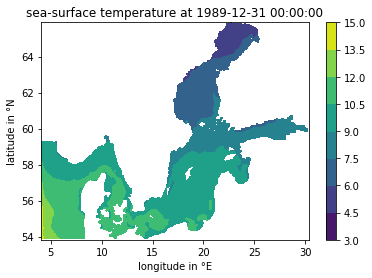

In [10]:
# first glance at data e.g. sea-surface temperature

ti = 10 # arbitrary temporal index

plt.figure()
plt.contourf(data['lon'][:], data['lat'][:], data['SST'][ti,:,:])

plt.colorbar()

plt.xlabel('longitude in °E')
plt.ylabel('latitude in °N')

plt.title('sea-surface temperature at ' + str(data['date'][ti]));

## A more specific task: Restricting data to a region of interest

We want to look at timeseries from the bottom of the deepest parts of the Gotland Basin.  But we do not have any depth info in the dataset.

Luckily, we know that down there, temperature variations are damped compared to the shallower parts of the Baltic Sea.  And we know where approximately the Gotland Basin is.

In [11]:
# Create a mask that is only true where the amplitude of the bottom temperature is below 0.3 K.
mask2d = (np.std(data['BTEMP'][...], axis=0).data < 0.30)

# limit values to the Gotland Basin ...
mask2d = mask2d * (data['lat'][...][:, np.newaxis] < 59.5)
mask2d = mask2d * (data['lon'][...][np.newaxis, :] < 22.0)

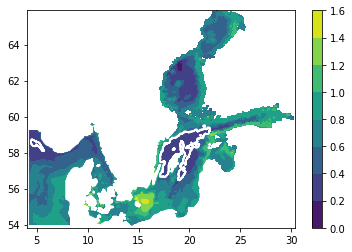

In [12]:
plt.figure() 

plt.contourf(data['lon'], data['lat'], np.std(data['BTEMP'], axis=0))

plt.colorbar()

plt.contour(data['lon'], data['lat'], mask2d, colors='w')

# also set labels and overlay a grid

# ...

---
---

Now, mask the data and plot histograms

In [13]:
# check if the shapes of the mask and the bottom temperature 
# work together:

# ...

---
---

In [14]:
masked_BTEMP = np.ma.where(mask2d, data['BTEMP'], np.ma.masked)

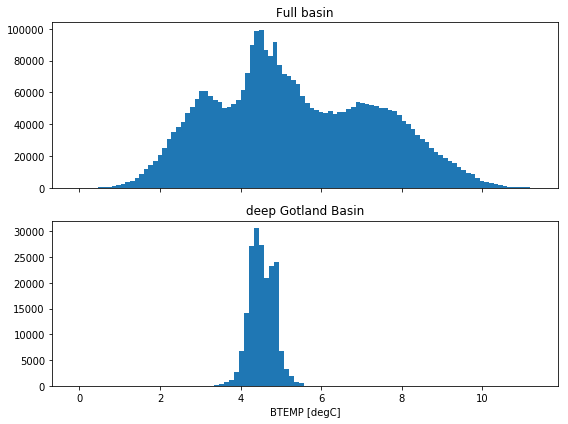

In [15]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

ax[0].hist(data['BTEMP'].compressed(), 100);
ax[0].set_title('Full basin')
ax[0].grid()

ax[1].hist(masked_BTEMP.compressed(), 20);
ax[1].set_title('deep Gotland Basin')
ax[0].grid()

ax[1].set_xlabel("BTEMP [degC]");

fig.tight_layout();

_**Note** how we use a different approach to modify the plot here._

Above, we used, e.g., `plt.xlabel('...')` to add labels, while here, we directly modify the axes object `ax[0]` and `ax[1]`.  The former is closer to an interactive and iterative creation of a figure while the latter is easier to handle if similar modifications are done to many plots.

Modifying the axes objects also allows for more precise customization of more complicated figures (controlling placement of colorbars, etc.).

## Key concepts from this notebook

- reading and inspecting netCDF data
- dict comprehensions
- creating and annotating plots
- boolean ndarrays
- masking arrays
- different ways of customizing plots (stateful vs. object-oriented)